In [4]:
# All code integrated: U-Net model, image preprocessing, model inference, and post-processing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image as PILImage
from torchvision import transforms
import torch.optim as optim
from IPython.display import Image, display
import os

# 设置设备
#device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# U-Net Components
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# U-Net Model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // 2)
        self.up1 = Up(1024, 512 // 2, bilinear)
        self.up2 = Up(512, 256 // 2, bilinear)
        self.up3 = Up(256, 128 // 2, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DiceLoss(nn.Module):
    """Dice loss, need inputs between 0 and 1."""
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        assert input.size() == target.size(), "Input sizes must be equal."
        assert input.dim() == 4, "Input must be a 4D Tensor."
        # Convert to float to ensure full precision during division
        input = torch.sigmoid(input).float()
        target = target.float()
        
        numerator = 2 * torch.sum(input * target, dim=(2, 3))
        denominator = torch.sum(input + target, dim=(2, 3))
        
        dice_score = (numerator + self.smooth) / (denominator + self.smooth)
        dice_loss = 1 - dice_score
        return dice_loss.mean()

# Load Pre-trained Model
def load_pretrained_model(model_path='model_best.pth', device='cpu'):
    # 确保UNet模型已经被定义在这个函数的外部
    model = UNet(n_channels=3, n_classes=1)
    # 加载预训练的权重，确保指定了map_location来适配你的设备
    model.load_state_dict(torch.load(model_path, map_location=device))
    # 将模型移动到指定的设备
    model.to(device)
    return model

# Image Preprocessing
def preprocess_image(image_path):
    # 直接从文件路径加载图片
    image = PILImage.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(image)
    input_tensor = input_tensor.unsqueeze(0)  # 增加一个批次维度
    return input_tensor

In [5]:
print(torch.cuda.is_available())

True


In [6]:
# Model Inference Function
def model_inference(model, input_tensor, device):
    input_tensor = input_tensor.to(device)  # 确保输入张量在正确的设备上
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradient for inference
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
        output = model(input_tensor)  # Forward pass
    return output

def inference_and_get_alphamap(image_path, device, model_path='model_best.pth'):
    model = load_pretrained_model(model_path, device)  # 加载模型和权重
    model.eval()  # 设置模型为评估模式

    # 图像预处理
    original_image = PILImage.open(image_path).convert("RGB")
    input_tensor = preprocess_image(image_path)
    input_tensor = input_tensor.to(device)  # 确保张量在正确的设备上

    # 模型推理
    with torch.no_grad():  # 不计算梯度
        output = model(input_tensor)  # 前向传播
    
    # 将输出应用Sigmoid函数转换成概率，进一步得到Alpha Map
    alpha_map = torch.sigmoid(output).squeeze().cpu().numpy()
    alpha_map = np.clip((alpha_map * 255).astype(np.uint8), 0, 255)  # 转换为0-255的整数

    # 调整Alpha Map的尺寸以匹配原始图像的尺寸
    original_width, original_height = original_image.size
    alpha_map_resized = cv2.resize(alpha_map, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

    return alpha_map_resized


# 保存Alpha Map的函数
def save_alpha_map(alpha_map, save_path='alpha_map.png'):
    PILImage.fromarray(alpha_map).save(save_path)

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob

# Custom Dataset Class for Image Segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = PILImage.open(image_path).convert("RGB")
        mask = PILImage.open(mask_path).convert("L")  # 加载为灰度图
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
            mask = torch.unsqueeze(mask, 0)  # 确保mask是单通道

        return image, mask

# Define the transform
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

# Function to match image files with their corresponding mask files
def get_matching_files(images_dir, masks_dir, image_ext=".jpg", mask_ext=".png"):
    image_files = sorted(glob.glob(os.path.join(images_dir, f"*{image_ext}")))
    mask_files = sorted(glob.glob(os.path.join(masks_dir, f"*{mask_ext}")))
    
    matched_images = []
    matched_masks = []

    image_basenames = {os.path.splitext(os.path.basename(image))[0]: image for image in image_files}
    mask_basenames = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in mask_files}

    total_images = len(image_basenames)
    print(f"Total images found: {total_images}")

    for basename, image_path in image_basenames.items():
        if basename in mask_basenames:
            matched_images.append(image_path)
            matched_masks.append(mask_basenames[basename])
            # processed += 1
            # print(f"Processed {processed}/{total_images} images.")
    
    print(f"Total matched images: {len(matched_images)}")
    return matched_images, matched_masks

# Training Function with Visualization
def train_and_evaluate_with_saving(model, train_loader, val_loader, optimizer, criterion, device, epochs, model_path='model_best.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0
        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Print the loss every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item()}")
                
        # Average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        # Average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}, Average Train Loss: {train_loss:.4f}, Average Val Loss: {val_loss:.4f}')

        # Save the model if it's the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f'Saved new best model at epoch {epoch+1} with Val Loss: {val_loss:.4f}')

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Total images found: 16184
Total matched images: 16184
Epoch [1/10], Batch [10/3237], Loss: 0.24892538785934448
Epoch [1/10], Batch [20/3237], Loss: 0.38272804021835327
Epoch [1/10], Batch [30/3237], Loss: 0.5762755274772644
Epoch [1/10], Batch [40/3237], Loss: 0.4387231767177582
Epoch [1/10], Batch [50/3237], Loss: 0.24416230618953705
Epoch [1/10], Batch [60/3237], Loss: 0.34871843457221985
Epoch [1/10], Batch [70/3237], Loss: 0.26286765933036804
Epoch [1/10], Batch [80/3237], Loss: 0.4446031153202057
Epoch [1/10], Batch [90/3237], Loss: 0.26755619049072266
Epoch [1/10], Batch [100/3237], Loss: 0.26144835352897644
Epoch [1/10], Batch [110/3237], Loss: 0.24987636506557465
Epoch [1/10], Batch [120/3237], Loss: 0.31937098503112793
Epoch [1/10], Batch [130/3237], Loss: 0.49647364020347595
Epoch [1/10], Batch [140/3237], Loss: 0.49276259541511536
Epoch [1/10], Batch [150/3237], Loss: 0.2959432601928711
Epoch [1/10], Batch [160/3237], Loss: 0.25589701533317566
Epoch [1/10], Batch [170/3237],

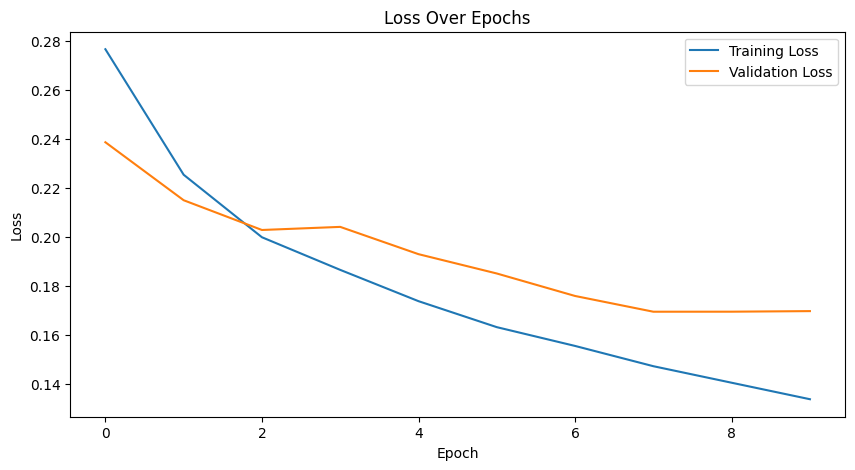

In [8]:
# Assuming you have a directory with images and their corresponding masks
images_dir='//home//lic9//prj//test//Dataset//complete_original'
masks_dir='//home//lic9//prj//test//Dataset//complete_alphamap'

# List image and mask files
image_files = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.png")))

# Use this function to filter out unmatched files
matched_image_files, matched_mask_files = get_matching_files(images_dir, masks_dir)

# Now you can proceed with splitting your data, setting up your dataset and dataloader as before
train_images, val_images, train_masks, val_masks = train_test_split(matched_image_files, matched_mask_files, test_size=0.2, random_state=42)

# Create Dataset and DataLoader
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# 加载和准备模型
model = load_pretrained_model().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Call the training function
# Note: Uncomment the next line to train the model. Make sure you have defined the paths and the dataset correctly.
train_and_evaluate_with_saving(model, train_loader, val_loader, optimizer, criterion, device, epochs=10)

In [ ]:
# Example usage
image1 = '/Users/tanqiwen/Desktop/test/Dataset/complete_original/GT04.png'
alpha_map = inference_and_get_alphamap(image1, device)  # 获取Alpha Map

# 指定Alpha Map的保存路径
saved_alpha_map_path = '/Users/tanqiwen/Desktop/test/alpha_map.png'
save_alpha_map(alpha_map, saved_alpha_map_path)  # 保存Alpha Map

# 然后你可以使用IPython.display来显示保存的图像，如之前所示
from IPython.display import Image, display
display(Image(filename=saved_alpha_map_path))
display(Image(filename=image1))